# Mock Target Contaminants - QSO Edition

The purpose of this notebook is to illustrate how *contaminants* are included in QSO (tracer+Lyman-alpha) spectral simulations generated using `desitarget/bin/select_mock_targets`.

The results below were generated with the tagged versions of the code in the `18.12` software release.

Additional information about simulating QSO targets (including contaminants) can be found on the [SimulateQuasarTargets](https://desi.lbl.gov/trac/wiki/LymanAlphaWG/SimulateQuasarTargets) wiki page.

John Moustakas  
Siena College  
2018 December 19 

#### Preliminaries.

In [1]:
import os

In [2]:
from desiutil.log import get_logger
log = get_logger()

In [3]:
import seaborn as sns
rc = {'font.family': 'serif'}#, 'text.usetex': True}
sns.set(style='ticks', font_scale=1.5, palette='Set2', rc=rc)

In [4]:
%matplotlib inline

## Target Densities

Recall that we expect with the current target selection algorithms (which will be tested extensively during Survey Validation) to obtain spectra of, on average, **`120 tracer QSOs/deg2`** (i.e., QSOs at z<2.1), **`50 Lya QSOs/deg2`** (i.e., QSOs at z>2.1), and **`90 contaminants/deg2`**.  Very roughly, approximately two-thirds of these contaminants will be stars and the remainder will be intermediate-redshift galaxies.  

However, a more detailed analyis of the Galactic and extragalactic objects expected to contaminate QSO target selection is clearly needed.

## Brief recap: how do we generate spectra for (mock) QSO targets?

1. Start with cosmological mocks which have RA, Dec, and redshift:
  * Tracer QSOs: `DarkSky/v1.0.1`
  * Lya QSOs: `london/v4.2.0`
  * The two mocks are stiched together precisely at `z=1.8` (including RSD) to avoid double-counting.
2. Use `desisim.templates.SIMQSO` to generate (continuum) spectra at the input redshift.
  * Under the hood, we draw from the BOSS/DR9 QSO luminosity function to get the apparent (normalization) magnitude of each QSO (accounting for the K-correction) and to synthesize (noiseless) *grzW1W2* photometry.
  * We perturb the photometry given the depth of our imaging and iteratively apply the latest target selection criteria (using color-cuts, not *random forest*) until we achieve the desired target density.
  * For the Lya QSOs target selection cuts are applied *after* Lya forest, BALs, etc. are included.
3. Finally, we write out `targets.fits` and `truth.fits` files (and spectra) with all the relevant catalog and ancillary data.

In [5]:
from desitarget.mock.mockmaker import QSOMaker, LYAMaker

In [6]:
QSO = QSOMaker()
data_tracer = QSO.read(only_coords=True, zmax_qso=1.8)

INFO:mockmaker.py:1266:readmock: Reading the whole DESI footprint with nside = 64.
INFO:mockmaker.py:212:_get_radec: Reading /Users/ioannis/work/desi/mocks/DarkSky/v1.0.1/qso_0_inpt.fits
INFO:mockmaker.py:217:_get_radec: Assigning healpix pixels with nside = 64.
INFO:mockmaker.py:1301:readmock: Trimmed to 5242322 QSOs in 18404 healpixel(s)
INFO:mockmaker.py:1321:readmock: Trimmed to 4117841 objects with z<1.800


In [7]:
qso_density = QSO.mock_density(QSO.default_mockfile)

#### Note that in general all the cosmological mocks are oversampled, so we have to subsample by a constant fraction in order to preserve the large-scale structure signal.

For example, we downsample the `DarkSky/QSO` mock by an average factor of 0.35 from 340/deg2 to 120/deg2.

In [8]:
log.info(QSO.default_mockfile)
log.info('Average density = {:.3f} QSO/deg2'.format(qso_density))

INFO:<ipython-input-8-4c7d65e925b7>:1:<module>: /Users/ioannis/work/desi/mocks/DarkSky/v1.0.1/qso_0_inpt.fits
INFO:<ipython-input-8-4c7d65e925b7>:2:<module>: Average density = 340.763 QSO/deg2


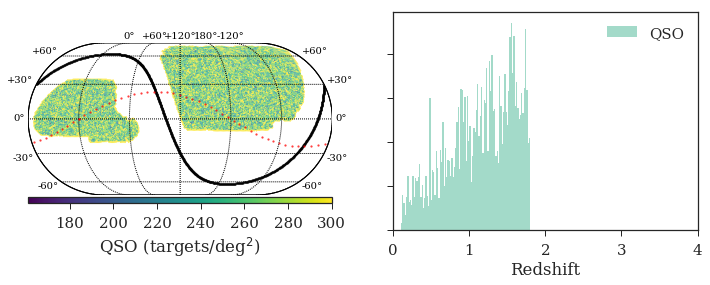

In [9]:
QSO.qamock_sky(data_tracer)

In [10]:
LYA = LYAMaker()
mockfile = os.path.join(os.getenv('DESI_ROOT'), 'mocks', 'lya_forest', 'london', 'v4.2.0', 'master.fits')
data_lya = LYA.read(mockfile=mockfile, only_coords=True, zmax_qso=1.8)

INFO:mockmaker.py:2112:readmock: Reading the whole DESI footprint with nside = 64.
INFO:mockmaker.py:2123:readmock: Reading /Users/ioannis/work/desi/mocks/lya_forest/london/v4.2.0/master.fits
INFO:mockmaker.py:2143:readmock: Assigning healpix pixels with nside = 64
INFO:mockmaker.py:2159:readmock: Trimmed to 2793122 LYAs in 18404 healpixel(s)


In [11]:
lya_density = LYA.mock_density(mockfile)

In [12]:
log.info(mockfile)
log.info('Average density = {:.3f} LYa QSO/deg2'.format(lya_density))

INFO:<ipython-input-12-6e9726dec47d>:1:<module>: /Users/ioannis/work/desi/mocks/lya_forest/london/v4.2.0/master.fits
INFO:<ipython-input-12-6e9726dec47d>:2:<module>: Average density = 181.105 LYa QSO/deg2


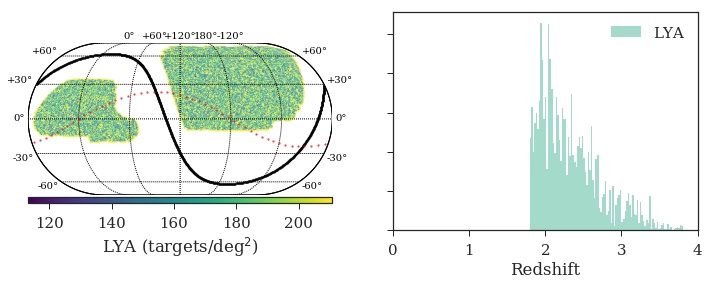

In [13]:
LYA.qamock_sky(data_lya)

## Contaminants: a wish list.

##### To properly include contaminants into our spectral simulations we need (for the kinds of objects that pass DESI/QSO target selection criteria):
* The correct redshift distribution (for extragalactic contaminants).
* A sensible spatial distribution (should not be random, since stellar contamination will vary with Galactic latitude).
* An optical luminosity function or, at the very least, a roughly correct apparent magnitude-redshift distribution.
* Spectral templates (so the correct multiband colors can be synthesized).

Fulfilling this wish-list will require non-negligible dedicated effort, with input from the Lya and Target Selection Working Groups. Alternatively, Survey Validation should provide all the necessary observations.

## Contaminants: current status.

Briefly, in the current version of `select_mock_targets` we use the following inputs.

##### Extragalactic contaminants:
* Use the `Buzzard/v1.6` mock (flux-limited to roughly r=24) for spatial coordinates and redshifts.
* Use the `desisim/BGS` templates (see, e.g., [this notebook](https://nbviewer.jupyter.org/github/desihub/desisim/blob/master/doc/nb/bgs-archetypes.ipynb)), as representative of the full range of spectral shapes spanned by galaxies.  (But note: these templates were trained on spectra of galaxies only down to `I<20.5`.)
* For speed, *pre-select* the templates (at a given redshift) that will pass QSO color-cuts and drawn from this subset of templates with uniform probability.
* Normalize each spectrum in the r-band using the QSO apparent magnitude distribution measured in DR7.1 (see [this notebook](https://nbviewer.jupyter.org/github/desihub/desitarget/blob/master/doc/nb/gmm-dr7.ipynb)).  (Note: doing this ignores the correlation between redshift and apparent magnitude.)

##### Galactic / stellar contaminants:
* Use the `MWS/v0.0.6` and `MWS-Superfaint/v0.0.6` mocks (flux-limited to r=23.5) to get spatial coordinates and radial velocities.
* Use the `desisim/STAR` templates (see [this notebook](https://nbviewer.jupyter.org/github/desihub/desisim/blob/master/doc/nb/star-templates.ipynb)).
* As for extragalactic contaminants, we pre-select the stellar templates that will pass QSO color-cuts and normalize to the appropriate QSO r-band magnitude distribution.

## Preliminary results.

Some preliminary results can be viewed by navigating to [targets-qa/QSO.html](http://portal.nersc.gov/project/desi/users/sjbailey/18.12rc3/targets-qa/QSO.html), which is based on spectral simulations (of all target classes, including contaminants) of 240k targets spanning 10 DESI tiles (roughly 40 deg2) generated as part of the 18.12 software release.

#### Target density

The final target density is close to the nominal density (OK given variations in large-scale structure), but would be nice to confirm over a larger footprint.

In [14]:
from IPython.display import Image, HTML, display

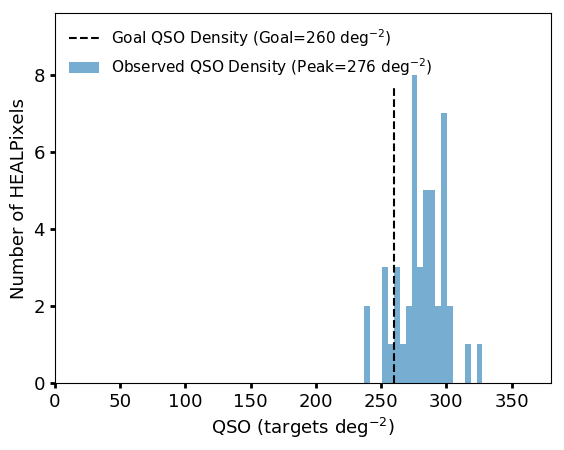

In [15]:
Image('histo-QSO.png')

#### Redshift distribution and apparent magnitude vs redshift relation.

* Overall the final redshift distribution is not terrible, given the simple assumptions used.
  * Not clear whether the "expected" dn/dz in `desimodel/data/targets/nz_QSO.dat` includes contaminants or not.
  * Need to test whether the redshift distribution of the extragalactic contaminants is sensible.
  * Too few Lya QSOs in the simulations?  Or perhaps an issue with `nz_QSO.dat`?
* Need to check that the apparent magnitude-redshift relation matches data.

In [16]:
display(HTML("<table><tr><td><img src='mock-nz-QSO.png'></td><td><img src='mock-zvmag-QSO.png'></td></tr></table>"))

,


## Conclusions, future work, and questions.

* Stellar contaminants are now included by default when simulating spectra using `select_mock_targets` for the QSO, ELG, LRG, and BGS target classes, and extragalactic contaminants are included for QSO and ELG targets.
* The model used to select contaminants is very rudimentary and requires dedicated effort to quantify the absolute (or, at minimum, apparent) magnitude distribution, redshift distribution, and spectral energy distributions of the contaminants *to DESI depth*.
* Still need to *look* at the simulated (DESI-like) spectra and test various QSO classification codes, including `redrock`.  In particular, have these contaminants had any effect on the derived catastrophic outlier rate?
* Should these changes be ported to `quickquasars`?  Or should `quickquasars` use the code infrastructure in `select_mock_targets`?